# [OPTIONAL]
# Compare ATL10 freeboard product with Sentinel-2 optical images

## 	&#x2B50; Objectives
- Query optical images in Google Earth Engine and download images overlapped with ICESat-2 track 
- Compare sea ice features from optical images and ICESat-2 ATL10 product

## &#x2705; Setting computing environment

We'll be using the following Python libraries in this notebook:

In [1]:
!pip install earthengine-api

  Using cached earthengine_api-0.1.361-py3-none-any.whl
  Using cached google_auth_httplib2-0.1.0-py2.py3-none-any.whl (9.3 kB)
  Using cached google_cloud_storage-2.10.0-py2.py3-none-any.whl (114 kB)
  Using cached google_api_python_client-2.95.0-py2.py3-none-any.whl (11.5 MB)
  Using cached google_auth-2.22.0-py2.py3-none-any.whl (181 kB)
  Using cached google_api_core-2.11.1-py3-none-any.whl (120 kB)
  Using cached uritemplate-4.1.1-py2.py3-none-any.whl (10 kB)
  Using cached pyasn1_modules-0.3.0-py2.py3-none-any.whl (181 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached cachetools-5.3.1-py3-none-any.whl (9.3 kB)
  Using cached google_resumable_media-2.5.0-py2.py3-none-any.whl (77 kB)
  Using cached google_cloud_core-2.3.3-py2.py3-none-any.whl (29 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 2.5 MB/s eta 0:00:0000:01
  Using cached protobuf-4.23.4-cp37-abi3-manylinux2014_x86_64.whl (304 kB)
  Using cached google_crc32c-1.5.0-cp310-cp310-manylinux_

In [13]:
!pip install geedim

  Using cached geedim-1.7.2-py3-none-any.whl (73 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


In [3]:
!pip install geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:0000:0100:01
  Using cached colour-0.1.5-py2.py3-none-any.whl (23 kB)
  Using cached ipyevents-2.0.1-py2.py3-none-any.whl (130 kB)
  Using cached geocoder-1.38.1-py2.py3-none-any.whl (98 kB)
  Using cached eerepr-0.0.4-py3-none-any.whl (9.7 kB)
  Using cached bqplot-0.12.40-py2.py3-none-any.whl (1.2 MB)
  Using cached ipyfilechooser-0.6.0-py3-none-any.whl (11 kB)
  Using cached pyperclip-1.8.2-py3-none-any.whl
  Using cached python_box-7.0.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.2 MB)
  Using cached scooby-0.7.2-py3-none-any.whl (16 kB)
  Using cached ipytree-0.2.2-py2.py3-none-any.whl (1.3 MB)
  Using cached ratelim-0.1.6-py2.py3-none-any.whl (4.0 kB)


In [4]:
import glob, os
import requests
import numpy as np

from datetime import datetime
from datetime import timedelta

import h5py
import pandas as pd

import os

import warnings
warnings.filterwarnings('ignore')

import geopandas
import rasterio

import ee
import geemap

%matplotlib widget
import matplotlib.pyplot as plt

## &#x2705; Google Earth Engine Authentication and Initialization
Before you start Google Earth Engine (`ee` library), you need to authenticate your access with your own Google account. This authentication can be done by running `ee.Authenticate()`. Please go to the link and allow the access, and you will be able to get an verification code. Please copy and paste this verification code into the input field and hit enter.

In [5]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

## &#x2705; Query Sentinel-2 images via Google Earth Engine using ATL10 track

In [6]:
# Read ATL10 track
filename = "processed_ATL10-02_20190916205836_12340401_005_02.h5"

with h5py.File(filename, 'r') as f:
    beam = 'gt2r'
    track = pd.DataFrame(data={'lat': f[beam]['freeboard_beam_segment']['beam_freeboard']['latitude'][:],
                               'lon': f[beam]['freeboard_beam_segment']['beam_freeboard']['longitude'][:],
                               'seg_x': f[beam]['freeboard_beam_segment']['beam_freeboard']['seg_dist_x'][:],
                               'freeboard': f[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_height'][:],
                               'type': f[beam]['freeboard_beam_segment']['height_segments']['height_segment_type'][:]
                              })

# Create Earth Engine feature collection with the ATL10 track
track_coord = list(zip([x for x in track.lon[::100]], [x for x in track.lat[::100]])) 
feature_track = ee.FeatureCollection(ee.Geometry.LineString(coords=track_coord, proj='EPSG:4326', geodesic=True)) 

# Define region of interest (ROI) using the ICESat-2 track feature collection
roi = feature_track.geometry()

In [7]:
# Read acquisition time of the ATL10 track from filename
time_atl = datetime.strptime(filename[19:33], "%Y%m%d%H%M%S")

In [8]:
# Start date (should be the ICESat-2 acquisition date)
t1 = datetime.strptime(filename[19:27], "%Y%m%d").strftime("%Y-%m-%d")

# End date (1 day after the ICESat-2 acquistion date)
t2 = (datetime.strptime(t1, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")

In [9]:
# Query Sentinel-2 images using ATL10 file information
S2 = ee.ImageCollection("COPERNICUS/S2_SR").filterBounds(roi)\
.filterDate(t1, t2)\
.filter(ee.Filter.lt('CLOUD_COVERAGE_ASSESSMENT', 20))\
.filter(ee.Filter.lt('NODATA_PIXEL_PERCENTAGE', 10))

In [10]:
num = S2.size().getInfo() # Number of available images
print(num)

2


In [11]:
# Image ID for all images
ids = [S2.toList(num).getInfo()[i]['id'] for i in range(0, num)] 
ids

['COPERNICUS/S2_SR/20190916T191509_20190916T191506_T03CVS',
 'COPERNICUS/S2_SR/20190916T191509_20190916T191506_T03CVT']

In [14]:
time_diff = 3600*3 # Time difference < 2 hours

Map = geemap.Map()

for i in range(0, num):
    time_start = S2.toList(num).getInfo()[i]['properties']['system:time_start']
    time_s2 = datetime(1970, 1, 1) + timedelta(seconds = time_start/1000)   
    
    img_name = os.path.basename(ids[i])

    # Time difference between IS2 and S2 < defined time_diff
    if abs(time_atl-time_s2).seconds <= time_diff:
        img = ee.Image(ids[i]).select('B4')
        dim = img.getInfo()['bands'][0]['dimensions']
        if dim[0] > 10000 and dim[1] > 0:
            geemap.download_ee_image(img, f"S2_{img_name}.tif", scale=50)
            Map.addLayer(img, {'min': 0, 'max': 10000}, img_name)
        else:
            print(f"SKIP {img_name}: Not a full image")
    else:
        print(f"SKIP {img_name}: Time difference > {time_diff/3600} hours with ICESat-2 track")

Map.centerObject(feature_track, zoom = 7)
Map.addLayer(feature_track, {}, "IS2 track")
Map

S2_20190916T191509_20190916T191506_T03CVS.tif: |          | 0.00/9.73M (raw) [  0.0%] in 00:00 (eta:     ?)

S2_20190916T191509_20190916T191506_T03CVT.tif: |          | 0.00/9.73M (raw) [  0.0%] in 00:00 (eta:     ?)

Map(center=[-75.78832982919852, -167.4174556669744], controls=(WidgetControl(options=['position', 'transparent…

## &#x2705; Comparison between ICESat-2 and Sentinel-2

Now we will compare the Sentinel-2 optical image we downloaded with the ICESat-2 ATL10 track.

In [35]:
# Read downloaded Sentinel-2 image
img_name = "S2_20190916T191509_20190916T191506_T03CVT.tif"

In [36]:
img = rasterio.open(img_name)
array = img.read(1)
array[array < 0] = 0

height = array.shape[0]
width = array.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(img.transform, rows, cols)
xs = np.array(xs)
ys = np.array(ys)

img.close()

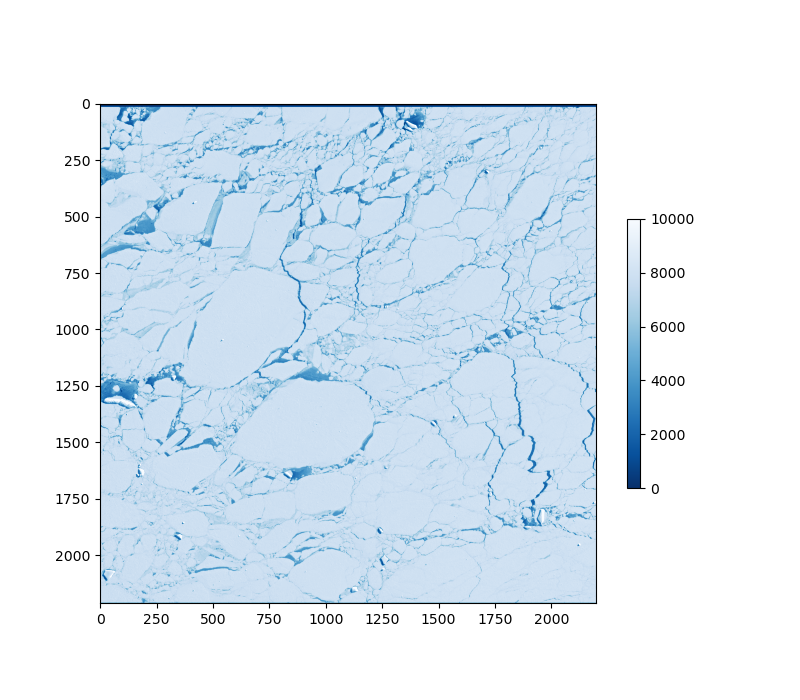

In [37]:
plt.figure(figsize = (8, 7))
plt.imshow(array, cmap = "Blues_r", vmin = 0, vmax = 10000)
plt.colorbar(shrink = 0.5)

Let's take a look at the ATL10 track data. We read the ATL10 h5 file as `pandas` dataframe. In order to assign the geographic coordinate information, we will convert this dataframe into `geopandas` geodataframe.

In [38]:
track

lat         lon         seg_x  freeboard  type  \
0     -73.993518 -166.372635  2.832895e+07   0.208310     1   
1     -73.993575 -166.372663  2.832896e+07   0.171925     1   
2     -73.993634 -166.372693  2.832897e+07   0.150621     1   
3     -73.993714 -166.372733  2.832897e+07   0.150800     1   
4     -73.993774 -166.372763  2.832898e+07   0.178065     1   
...          ...         ...           ...        ...   ...   
42686 -77.597688 -168.750844  2.873643e+07   0.261691     1   
42687 -77.598633 -168.751615  2.873654e+07   0.173053     7   
42688 -77.599058 -168.751960  2.873659e+07   0.160000     7   
42689 -77.599587 -168.752393  2.873665e+07   0.125644     9   
42690 -77.606047 -168.757733  2.873738e+07   0.149021     1   

                           geometry  
0      POINT (-166.37263 -73.99352)  
1      POINT (-166.37266 -73.99357)  
2      POINT (-166.37269 -73.99363)  
3      POINT (-166.37273 -73.99371)  
4      POINT (-166.37276 -73.99377)  
...                             ...  
42686  POINT (-168.75084 -77.59769)  
42687  POINT (-168.75161 -77.59863)  
42688  POINT (-168.75196 -77.59906)  
42689  POINT (-168.75239 -77.59959)  
42690  POINT (-168.75773 -77.60605)  

[42691 rows x 6 columns]

In [39]:
# Convert pandas dataframe into geopandas geodataframe
gdf = geopandas.GeoDataFrame(track, geometry=geopandas.points_from_xy(track.lon, track.lat))

# Assign crs information into geodatafraem
gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

# Convert crs of the geodataframe into the crs of the Sentinel-2 image
gdf = gdf.to_crs(img.crs)

In [40]:
gdf

lat         lon         seg_x  freeboard  type  \
0     -73.993518 -166.372635  2.832895e+07   0.208310     1   
1     -73.993575 -166.372663  2.832896e+07   0.171925     1   
2     -73.993634 -166.372693  2.832897e+07   0.150621     1   
3     -73.993714 -166.372733  2.832897e+07   0.150800     1   
4     -73.993774 -166.372763  2.832898e+07   0.178065     1   
...          ...         ...           ...        ...   ...   
42686 -77.597688 -168.750844  2.873643e+07   0.261691     1   
42687 -77.598633 -168.751615  2.873654e+07   0.173053     7   
42688 -77.599058 -168.751960  2.873659e+07   0.160000     7   
42689 -77.599587 -168.752393  2.873665e+07   0.125644     9   
42690 -77.606047 -168.757733  2.873738e+07   0.149021     1   

                             geometry  
0      POINT (457755.134 1788198.584)  
1      POINT (457754.406 1788192.277)  
2      POINT (457753.640 1788185.637)  
3      POINT (457752.604 1788176.653)  
4      POINT (457751.838 1788170.017)  
...                               ...  
42686  POINT (410129.110 1383653.885)  
42687  POINT (410117.406 1383547.402)  
42688  POINT (410112.173 1383499.577)  
42689  POINT (410105.600 1383439.933)  
42690  POINT (410023.994 1382712.259)  

[42691 rows x 6 columns]

In [41]:
# Save coordinate information as independent columns (x, y)
gdf['x'] = gdf.geometry.apply(lambda x: x.x)
gdf['y'] = gdf.geometry.apply(lambda x: x.y)

# Boundary of the image
x_min = xs.min()
x_max = xs.max()
y_min = ys.min()
y_max = ys.max()

# Clip geodataframe fitting to the image extent
gdf = gdf[(gdf["x"]>=x_min) & (gdf["x"]<=x_max) & (gdf["y"]>=y_min) & (gdf["y"]<=y_max)].reset_index(drop=True)

idx = img.index(gdf["x"], gdf["y"])
gdf["pix_x"] = idx[1]
gdf["pix_y"] = idx[0]

In [42]:
gdf

lat         lon         seg_x  freeboard  type  \
0     -73.993518 -166.372635  2.832895e+07   0.208310     1   
1     -73.993575 -166.372663  2.832896e+07   0.171925     1   
2     -73.993634 -166.372693  2.832897e+07   0.150621     1   
3     -73.993714 -166.372733  2.832897e+07   0.150800     1   
4     -73.993774 -166.372763  2.832898e+07   0.178065     1   
...          ...         ...           ...        ...   ...   
13860 -74.868143 -166.856996  2.842764e+07   0.582343     1   
13861 -74.868201 -166.857029  2.842765e+07   0.665967     1   
13862 -74.868271 -166.857068  2.842766e+07   0.836995     1   
13863 -74.868327 -166.857100  2.842767e+07   0.812481     1   
13864 -74.868380 -166.857130  2.842767e+07   0.801100     1   

                             geometry              x             y  pix_x  \
0      POINT (457755.134 1788198.584)  457755.133995  1.788199e+06   1157   
1      POINT (457754.406 1788192.277)  457754.406235  1.788192e+06   1157   
2      POINT (457753.640 1788185.637)  457753.640184  1.788186e+06   1157   
3      POINT (457752.604 1788176.653)  457752.603646  1.788177e+06   1157   
4      POINT (457751.838 1788170.017)  457751.837735  1.788170e+06   1157   
...                               ...            ...           ...    ...   
13860  POINT (445898.307 1690258.462)  445898.307021  1.690258e+06    919   
13861  POINT (445897.567 1690252.010)  445897.566588  1.690252e+06    919   
13862  POINT (445896.660 1690244.153)  445896.659846  1.690244e+06    919   
13863  POINT (445895.938 1690237.853)  445895.938187  1.690238e+06    919   
13864  POINT (445895.246 1690231.874)  445895.246216  1.690232e+06    919   

       pix_y  
0        254  
1        254  
2        254  
3        254  
4        254  
...      ...  
13860   2212  
13861   2212  
13862   2213  
13863   2213  
13864   2213  

[13865 rows x 10 columns]

Draw overlapped optical image and ATL10 surface types.

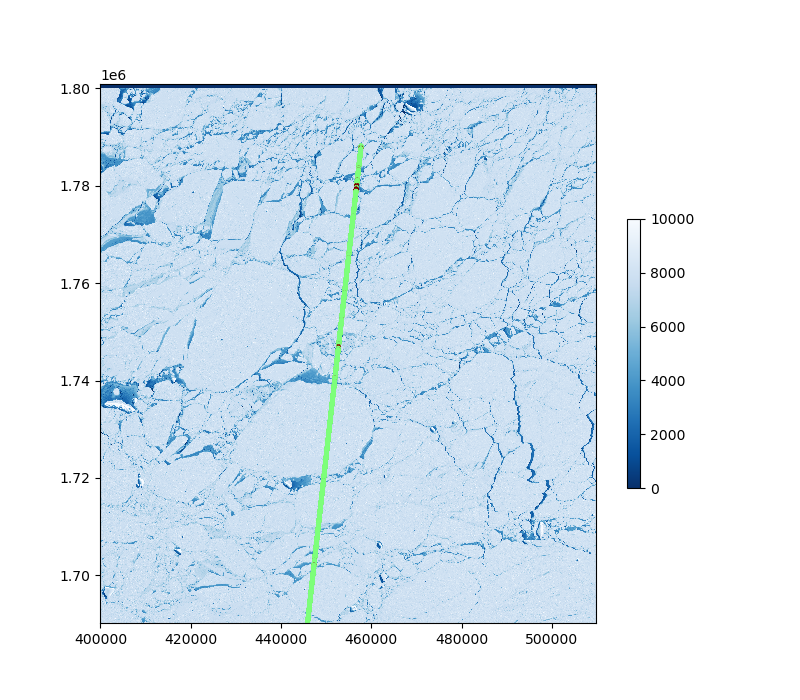

In [43]:
plt.figure(figsize = (8,7))
plt.pcolormesh(xs, ys, array, vmin = 0, vmax = 10000, cmap = "Blues_r")
plt.colorbar(shrink = 0.5)
plt.scatter(gdf['x'], gdf['y'], c = gdf['type'], s = 5, vmin = 0, vmax = 2, cmap = "jet")

Draw optical image and ATL10 freeboard.

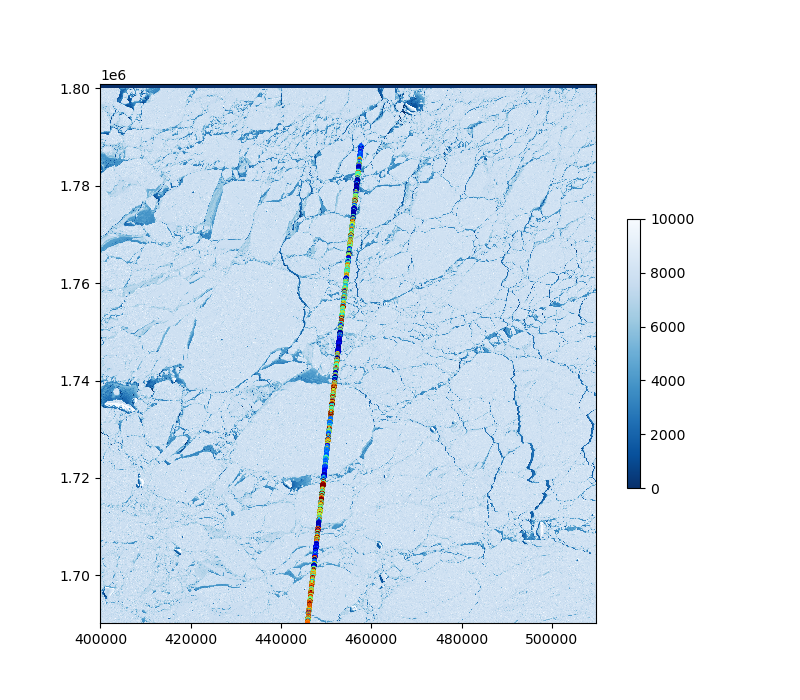

In [44]:
plt.figure(figsize = (8,7))
plt.pcolormesh(xs, ys, array, vmin = 0, vmax = 10000, cmap = "Blues_r")
plt.colorbar(shrink = 0.5)
plt.scatter(gdf['x'], gdf['y'], c = gdf['freeboard'], s = 5, vmin = 0, vmax = 1, cmap = "jet")

## &#x2705; Floe statistics from ICESat-2 and Sentinel-2

Based on the overlapped Sentinel-2 optical image, we will calculate floe statistics. Since the optical image can be a good reference of lead detection, we compare the lead frequency and floe size distribution from the ATL10 data and Sentinel-2 optical image.

First, let's do a simple lead detection with the Sentinel-2 brigtness value. The dark area should be lead, and the white area should be sea ice floes.

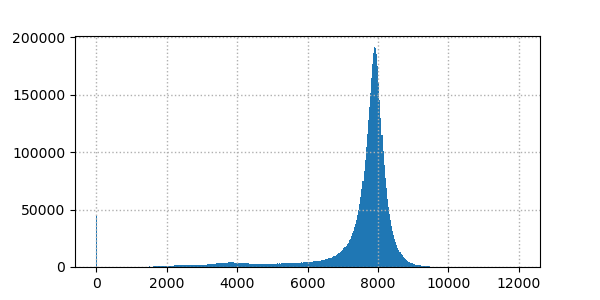

In [45]:
# Histogram of pixel value
plt.figure(figsize = (6,3))
plt.hist(array.flatten(), range = (0, 12000), bins = 400)
plt.grid(ls = ":", lw = 1);

Based on this histogram, which value is appropriate to separate sea ice floes and leads?

In [46]:
# Threshold value to separate sea ice floes and leads
th = 7000

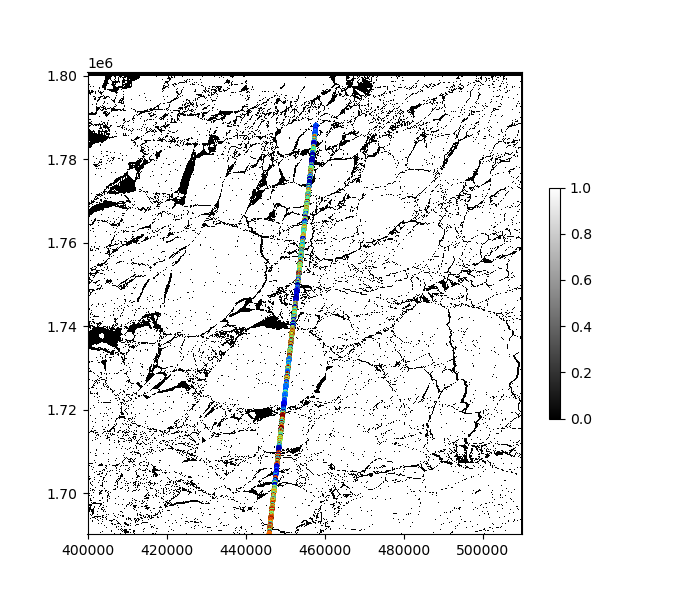

In [47]:
# Lead classification (0: lead, 1: sea ice floe)
classified = np.zeros(np.shape(array))
classified[array >= th] = 1

# Draw the lead classification image
plt.figure(figsize = (7,6))
plt.pcolormesh(xs, ys, classified, cmap = "gray")
plt.colorbar(shrink = 0.5)
plt.scatter(gdf['x'], gdf['y'], c = gdf['freeboard'], s = 5, vmin = 0, vmax = 1, cmap = "jet")
plt.show()

In [48]:
# Resample the raster value to the ICESat-2 track geodataframe
idx = img.index(gdf["x"], gdf["y"])
gdf["b4"] = array[idx[0], idx[1]]
gdf["lead_S2"] = classified[idx[0], idx[1]]

Now we will calculate the floe size statistics.

In [49]:
# Function to calculate sea ice floe length
def get_floe_length(freeboard, lead_mask, seg_dist):
    # INPUT:
    # freeboard: along-track freeboard measurement of ICESat-2 ATL10 track
    # lead_mask: along-track lead detection result (0: lead; 1: non-lead)
    # seg_dist: along-track distance of ICESat-2 ATL10 track (unit: meters)
    
    floe_length = np.array([]) # Floe length (unit: m)
    lead_length = np.array([]) # Floe length (unit: m)
    floe_fb = np.array([]) # np.zeros(len(ice_leads_msk)) # Making big enough array
    
    # Floe starting index
    ice_cnt_st = 0
    # Floe ending index
    ice_cnt_en = 0
    
    # Lead starting index
    lead_cnt_st = 0
    # Lead ending index
    lead_cnt_en = 0
    
    for i in range(1,len(freeboard)):
        if (lead_mask[i] == 1) and (lead_mask[i-1] == 0): # start floe & stop lead
            # Initialize floe
            ice_cnt_st = i
            ice_cnt_en = i
            
            # Complete lead
            lead_length = np.append(lead_length, abs(seg_dist[lead_cnt_en] - seg_dist[lead_cnt_st]))
                                    
        elif (lead_mask[i] == 1) and (lead_mask[i-1] == 1): # grow floe
            ice_cnt_en += 1
            
        elif (lead_mask[i] == 0) and (lead_mask[i-1] == 0): # grow lead
            lead_cnt_en += 1
            
        elif (lead_mask[i] == 0) and (lead_mask[i-1] == 1): # stop floe & start lead
            # Complete floe
            floe_length = np.append(floe_length, abs(seg_dist[ice_cnt_en] - seg_dist[ice_cnt_st]))
            floe_fb = np.append(floe_fb, np.mean(freeboard[ice_cnt_st:ice_cnt_en+1]))
            
            # Initialize lead
            lead_cnt_st = i
            lead_cnt_en = i
        
            
    # Removing spurious floes (< 50m, > 10 km, fb < 0.1)
    remove_idx = np.where((floe_length < 50) | (floe_length > 10000) | (floe_fb < 0.1))[0]  
    floe_fb = np.delete(floe_fb, remove_idx)
    floe_length = np.delete(floe_length,remove_idx)
    
    remove_idx = np.where(lead_length < 10)[0]
    lead_length = np.delete(lead_length,remove_idx)

    return floe_length, floe_fb, lead_length


In [50]:
# Freeboard lead mask (lead if freeboard < 0.15 m)
lead_mask = (gdf.freeboard >= 0.15).values # Lead should be 0
floe_length1, floe_fb1, lead_length1 = get_floe_length(gdf.freeboard, lead_mask, gdf.seg_x)

In [51]:
# Overlapped Sentinel-2 lead mask (lead if pixel value < threshold)
lead_mask = gdf.lead_S2.values # Lead should be 0
floe_length2, floe_fb2, lead_length2 = get_floe_length(gdf.freeboard, lead_mask, gdf.seg_x)

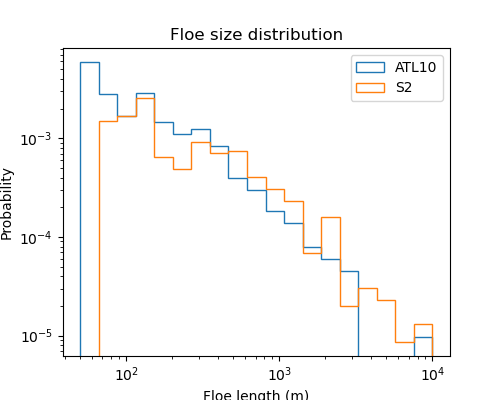

In [52]:
# FLoe length distribution

plt.figure(figsize = (5,4))

# Histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(50),np.log10(10000), 20)
plt.hist(floe_length1, bins=logbins, density = True, histtype = "step", label = "ATL10")
plt.hist(floe_length2, bins=logbins, density = True, histtype = "step", label = "S2")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Floe length (m)")
plt.ylabel("Probability")
plt.title("Floe size distribution")
plt.legend()
plt.show()


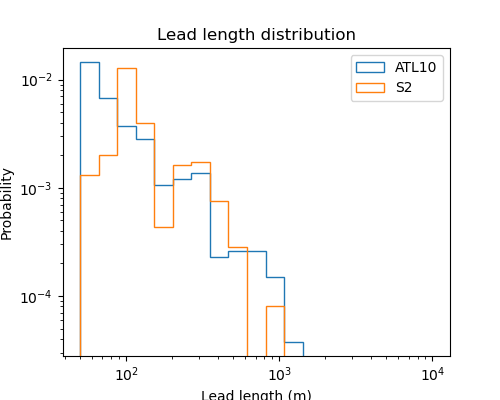

In [53]:
# Lead length distribution

plt.figure(figsize = (5,4))

# Histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(50), np.log10(10000), 20)
plt.hist(lead_length1, bins=logbins, density = True, histtype = "step", label = "ATL10")
plt.hist(lead_length2, bins=logbins, density = True, histtype = "step", label = "S2")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Lead length (m)")
plt.ylabel("Probability")
plt.title("Lead length distribution")
plt.legend()
plt.show()

#### Credited by Younghyun Koo (kooala317@gmail.com)